## XGBoost ML-Model. 

###### A. part of Notebook is regional learning with the Icelandic dataset. B. part is transfer learning with Swiss/GLAMOS train set and Icelandic test set

### Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging

from scripts.helpers import *
from scripts.iceland_preprocess import *
from scripts.plots import *
from scripts.config_ICE import *
from scripts.xgb_helpers import *


# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.IcelandConfig()

In [ ]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "consensus_ice_thickness",
    "millan_v",
]

#### A.1. Read in stake data from preprocess, transform to monthly and add ERA5Land data

###### Load csv into df

In [3]:
data_wgms = pd.read_csv(path_PMB_WGMS_csv + 'ICE_dataset_all_oggm.csv')

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns

Number of glaciers: 49
Number of winter, summer and annual samples: 6546
Number of annual samples: 3185
Number of winter samples: 3361
Number of summer samples: 0


Index(['POINT_ELEVATION', 'POINT_LAT', 'POINT_LON', 'DATA_MODIFICATION',
       'FROM_DATE', 'TO_DATE', 'POINT_BALANCE', 'PERIOD', 'YEAR', 'RGIId',
       'aspect', 'slope', 'topo', 'consensus_ice_thickness', 'millan_v',
       'GLACIER', 'POINT_ID'],
      dtype='object')

###### Transform into monthly and add ERA5Land

In [5]:
data_wgms_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_WGMS_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data_ICECH.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file='ICE_dataset_monthly_full.csv')
data_monthly = dataloader_gl.data

display(data_monthly.head(2))

2025-06-09 20:26:59,414 - INFO - Number of annual and seasonal samples: 6546
2025-06-09 20:26:59,416 - INFO - Running on 49 glaciers:
['Skeidararjoekull' 'Dyngjujoekull' 'Breidamerkurjoekull' 'RGI60-06.00303'
 'Langjoekull Ice Cap' 'Hagafellsjoekull West'
 'Sidujoekull/Skaftarjoekull' 'Koeldukvislarjoekull' 'RGI60-06.00359'
 'RGI60-06.00238' 'Hagafellsjoekull East (Langjoekull S Dome)'
 'RGI60-06.00466' 'Tungnaarjoekull' 'RGI60-06.00232' 'Bruarjoekull'
 'RGI60-06.00411' 'RGI60-06.00422' 'RGI60-06.00292' 'RGI60-06.00328'
 'RGI60-06.00340' 'Blagnipujoekull (Hofsjoekull SW)' 'RGI60-06.00294'
 'RGI60-06.00302' 'RGI60-06.00311' 'Oeldufellsjoekull' 'Eyjabakkajoekull'
 'RGI60-06.00320' 'RGI60-06.00478' 'RGI60-06.00465' 'RGI60-06.00301'
 'RGI60-06.00305' 'RGI60-06.00409' 'Sylgjujoekull'
 'Thjorsarjoekull (Hofsjoekull E)' 'RGI60-06.00480' 'RGI60-06.00476'
 'RGI60-06.00413' 'RGI60-06.00350' 'Mulajoekull' 'RGI60-06.00349'
 'Slettjoekull West' 'RGI60-06.00228' 'RGI60-06.00342' 'RGI60-06.00425'
 'R

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2007.0 -17.410172  64.555705       1.785833       1703.715905   
1  2007.0 -17.410172  64.555705       1.785833       1703.715905   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0             40.674095          1744.39  RGI60-06.00475   
1             40.674095          1744.39  RGI60-06.00475   

                                POINT_ID  ID  ...  millan_v        t2m  \
0  Skeidararjoekull_2007.0_annual_Gjal28   0  ...   26.5329  -5.689545   
1  Skeidararjoekull_2007.0_annual_Gjal28   0  ...   26.5329 -10.739105   

         tp      slhf      sshf       ssrd       fal        str       u10  \
0  0.004581 -135748.0  482898.0  4067512.0  0.850005 -1431300.0 -3.467090   
1  0.006718  193162.0  744062.0   919344.0  0.849998 -1265354.0 -1.604117   

        v10  
0 -0.109194  
1  0.086881  

[2 rows x 27 columns]

#### A.2. Dataset statistics

In [ ]:
plotHeatmap(data_monthly, period='annual', plot_elevation=True)

In [ ]:
data_monthly.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_orange, color_pink])
plt.title('Number of measurements per year for all glaciers')

In [ ]:
# Plot feature intercorrelation
plot_feature_correlation(dataloader_gl.data)

In [ ]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

In [ ]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate
df = df[(df.GLACIER == 'FR4N01235A08 dArgentiere') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

### A.3. Train-test set split:
##### A.3.1. Spatial Cross-Validation

###### Uses specific glaciers as test set

In [ ]:
Langjokul = dataloader_gl.data[
    (dataloader_gl.data['POINT_LON'] < -19.4) & 
    (dataloader_gl.data['POINT_LAT'] > 64.3)
]['GLACIER'].unique()
display(Langjokul)

In [ ]:
test_glaciers = ['Hagafellsjoekull West', 'RGI60-06.00303', 'Langjoekull Ice Cap',
       'RGI60-06.00302', 'Hagafellsjoekull East (Langjoekull S Dome)',
       'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00301',
       'RGI60-06.00311', 'RGI60-06.00305', 'RGI60-06.00306',
       'RGI60-06.00296']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

###### Remove summer rows if present

In [10]:
# Remove summer stakes
dataloader_gl.data = dataloader_gl.data[dataloader_gl.data['PERIOD'] != 'summer']
dataloader_gl.data = dataloader_gl.data.reset_index(drop=True)
data_monthly = dataloader_gl.data

display(dataloader_gl.data['PERIOD'].unique())

array(['annual', 'winter'], dtype=object)

#### Spatial Distribution

###### Find GLACIER names of the two icecaps to the north-west

In [12]:
Langjokul = dataloader_gl.data[
    (dataloader_gl.data['POINT_LON'] < -19.4) & 
    (dataloader_gl.data['POINT_LAT'] > 64.3)
]['GLACIER'].unique()
display(Langjokul)

array(['RGI60-06.00303', 'Langjoekull Ice Cap', 'Hagafellsjoekull West',
       'Hagafellsjoekull East (Langjoekull S Dome)', 'RGI60-06.00292',
       'RGI60-06.00294', 'RGI60-06.00302', 'RGI60-06.00311',
       'RGI60-06.00301', 'RGI60-06.00305', 'RGI60-06.00306',
       'RGI60-06.00296'], dtype=object)

###### Create Test and Train set

In [ ]:
test_glaciers = ['Hagafellsjoekull West', 'RGI60-06.00303', 'Langjoekull Ice Cap',
       'RGI60-06.00302', 'Hagafellsjoekull East (Langjoekull S Dome)',
       'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00301',
       'RGI60-06.00311', 'RGI60-06.00305', 'RGI60-06.00306',
       'RGI60-06.00296']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

##### A.3.2. Temporal Cross-Validation

###### Uses the last X years as test set

In [ ]:
test_years_count = 10

all_years = sorted(dataloader_gl.data['YEAR'].unique())

# Use the most recent years as test data
train_years = all_years[:-test_years_count]
test_years = all_years[-test_years_count:]

# Statistics prints
print('Size of test data:', len(test_years))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_years)]
print('Size of train data:', len(train_years))
if len(train_years) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(test_years) / len(train_years)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(
                                dataloader_gl,
                                test_split_on='YEAR',
                                test_splits=test_years,
                                random_state=cfg.seed)


print('Train year: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test years: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

##### A.3.3. Train-Test set plots

In [ ]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

#### A.4. XGBoost:

In [16]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    #"hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

###### Grid search:

In [17]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_Iceland.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_Iceland.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (50663, 25)
Shape of testing dataset: (11419, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'consensus_ice_thickness', 'millan_v']
Best parameters:
 {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.6136214059281291
Shape of the test: (11419, 14)
Overall score: 1.1109134188567678
CPU times: user 1.6 s, sys: 139 ms, total: 1.74 s
Wall time: 313 ms


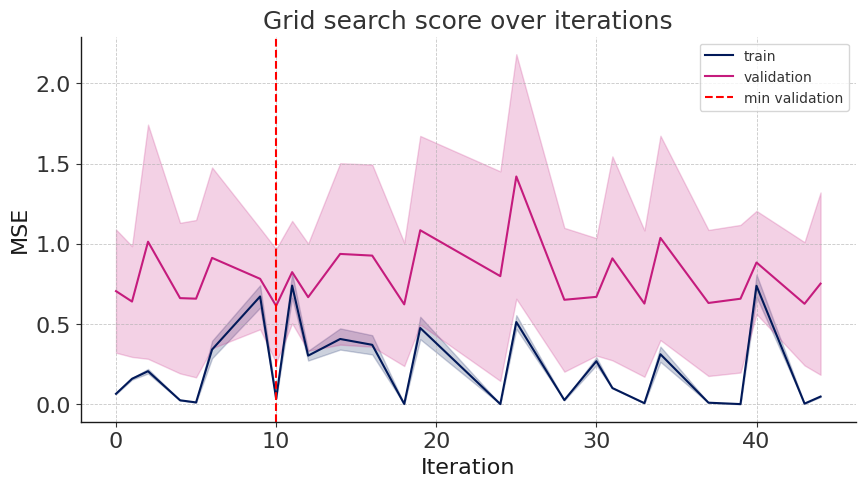

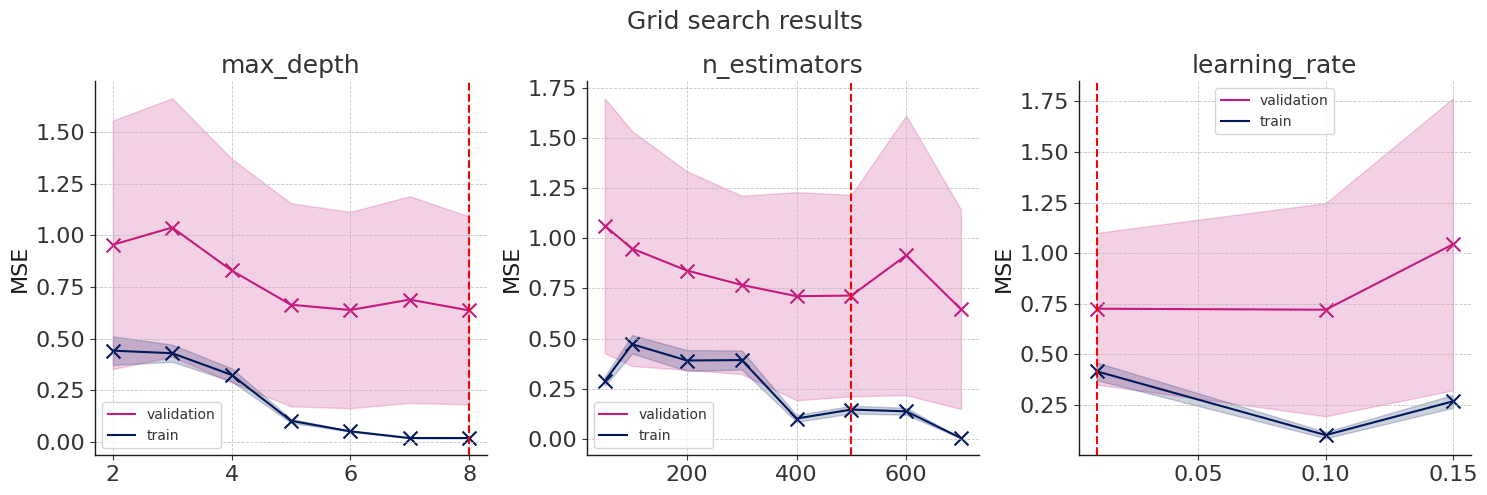

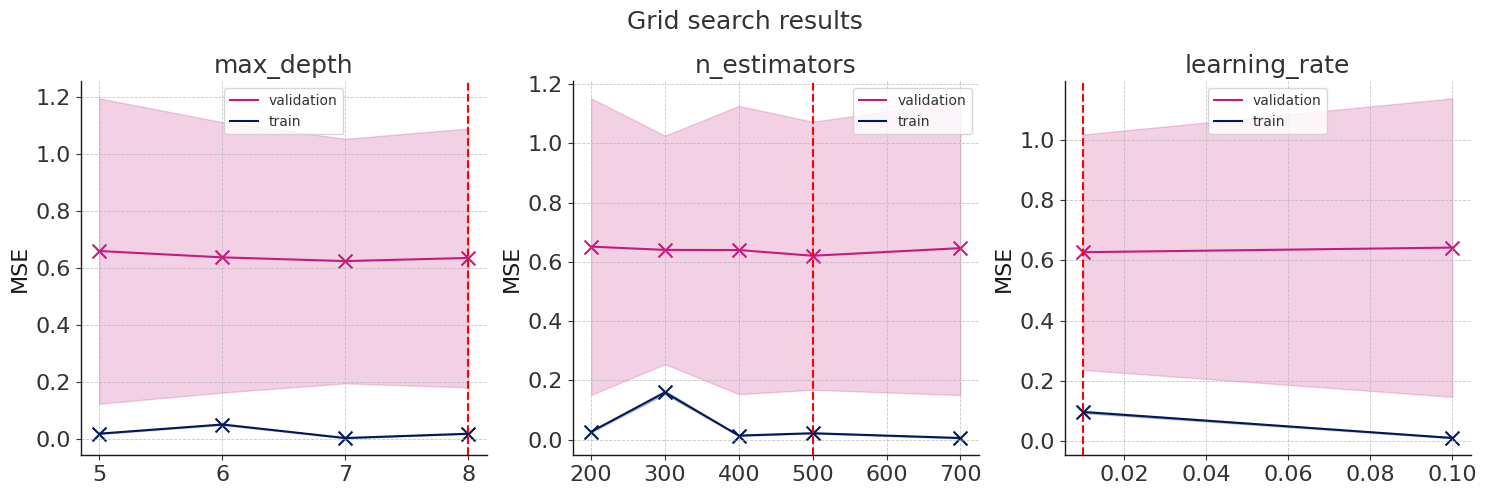

In [18]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

print_top_n_models(custom_xgboost.param_search.cv_results_)

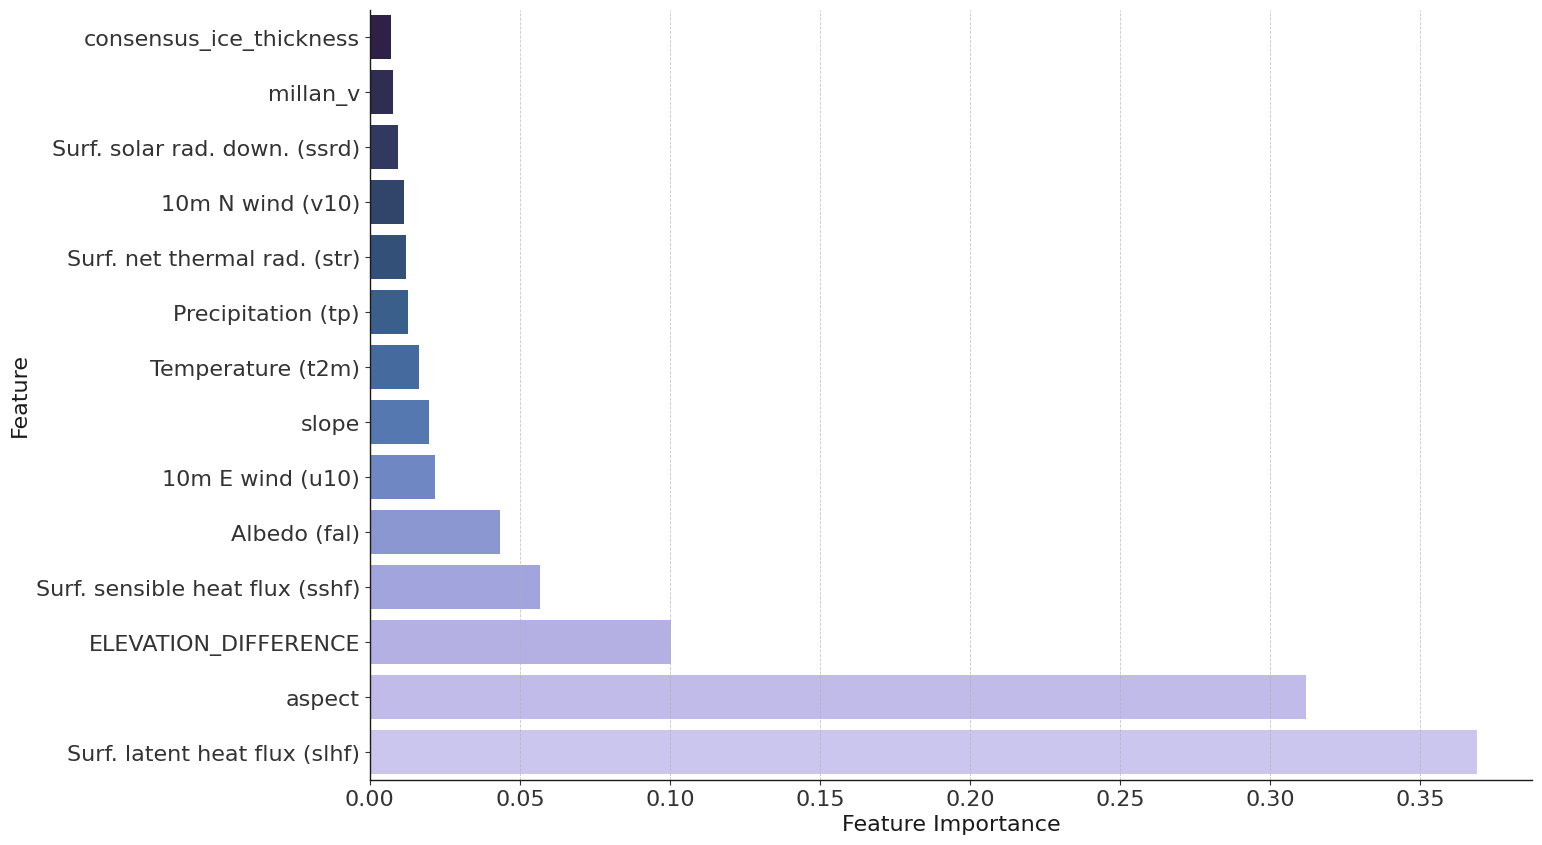

In [19]:
FIPlot(best_estimator, feature_columns, vois_climate)

###### Predictions of best parameters:

Shape of the test: (11419, 14)


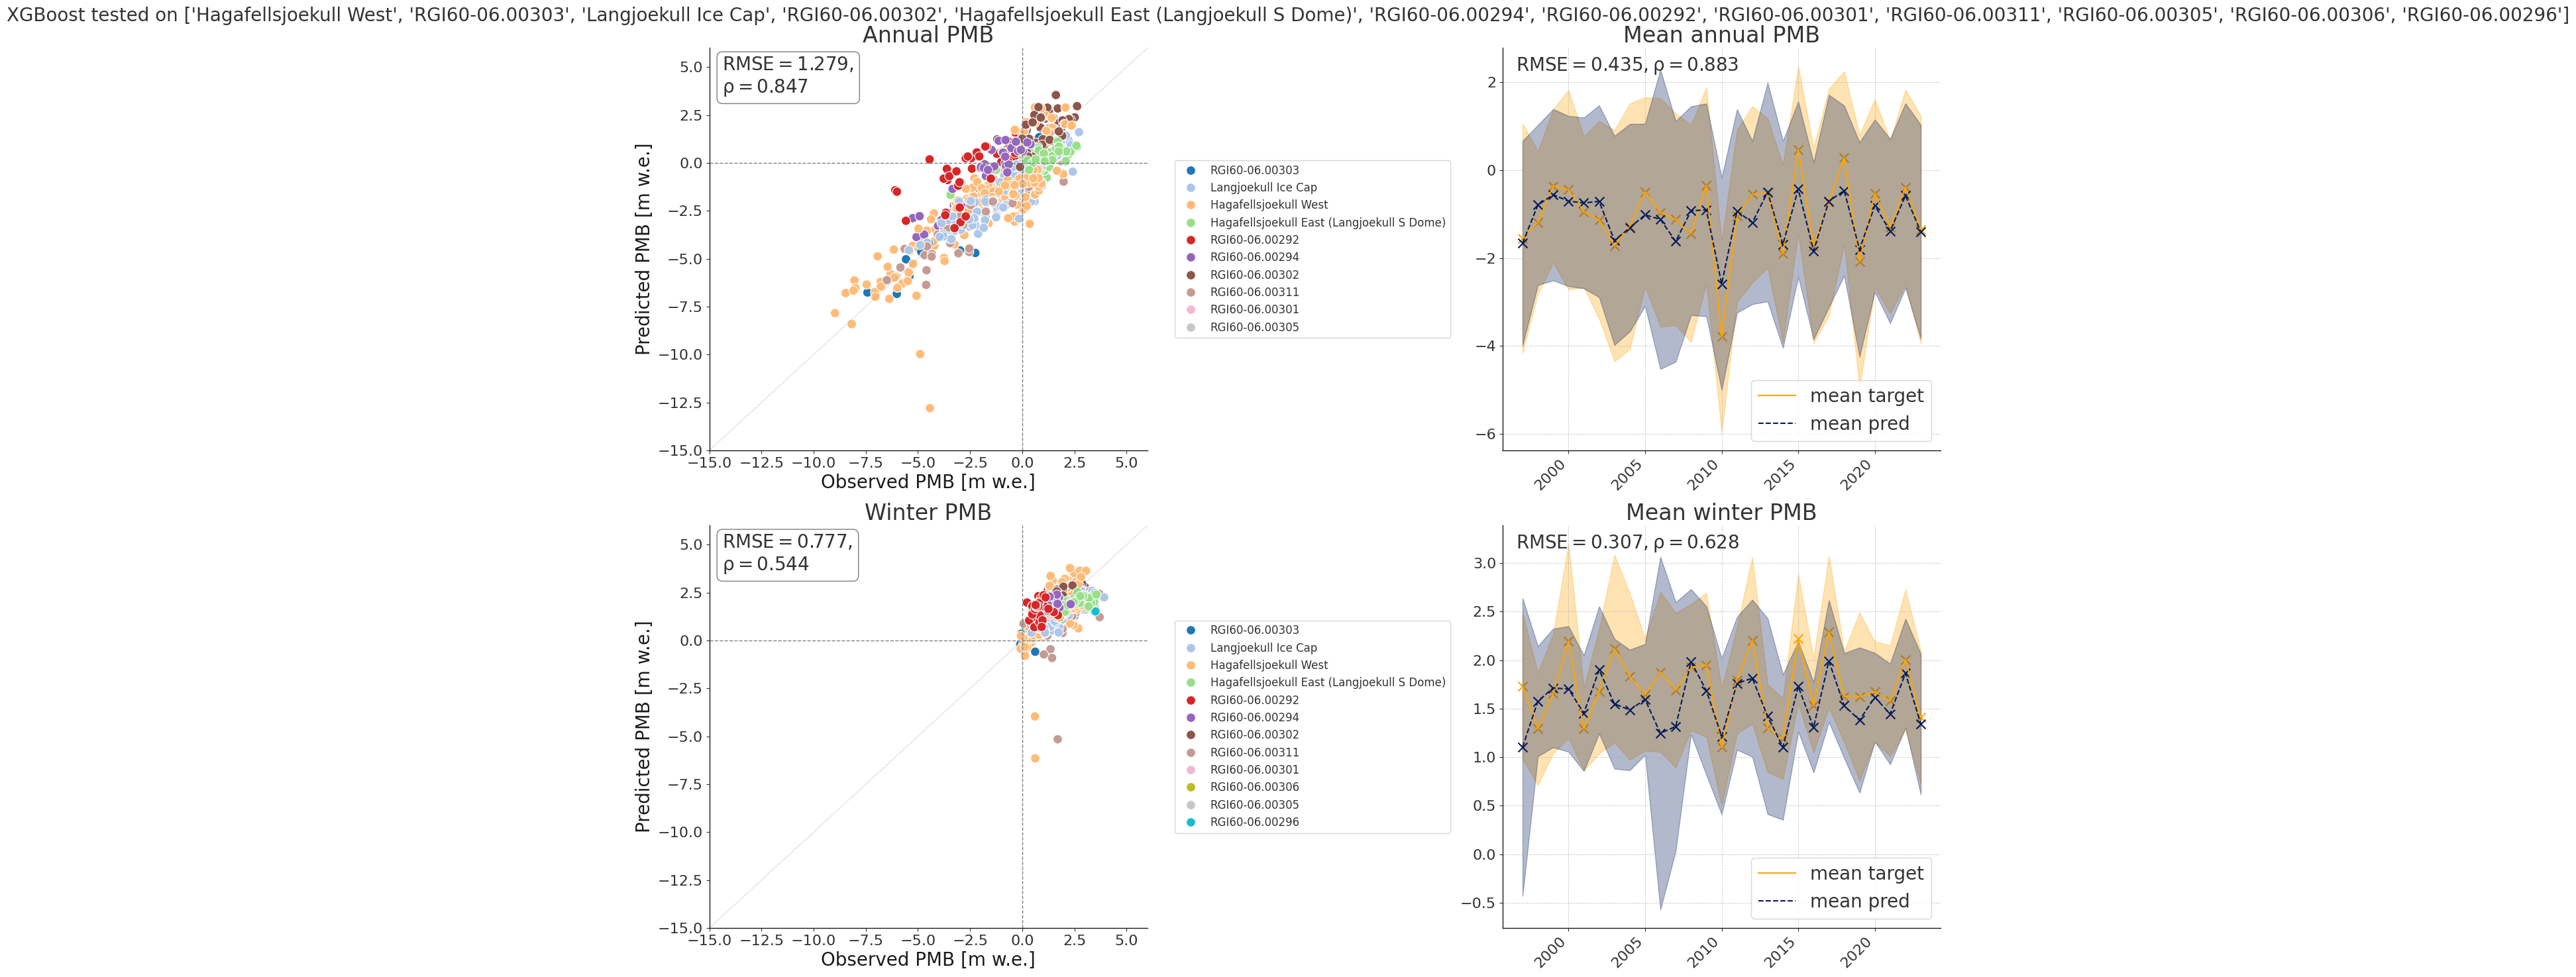

In [20]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, include_summer=False)
plt.suptitle(f'XGBoost tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

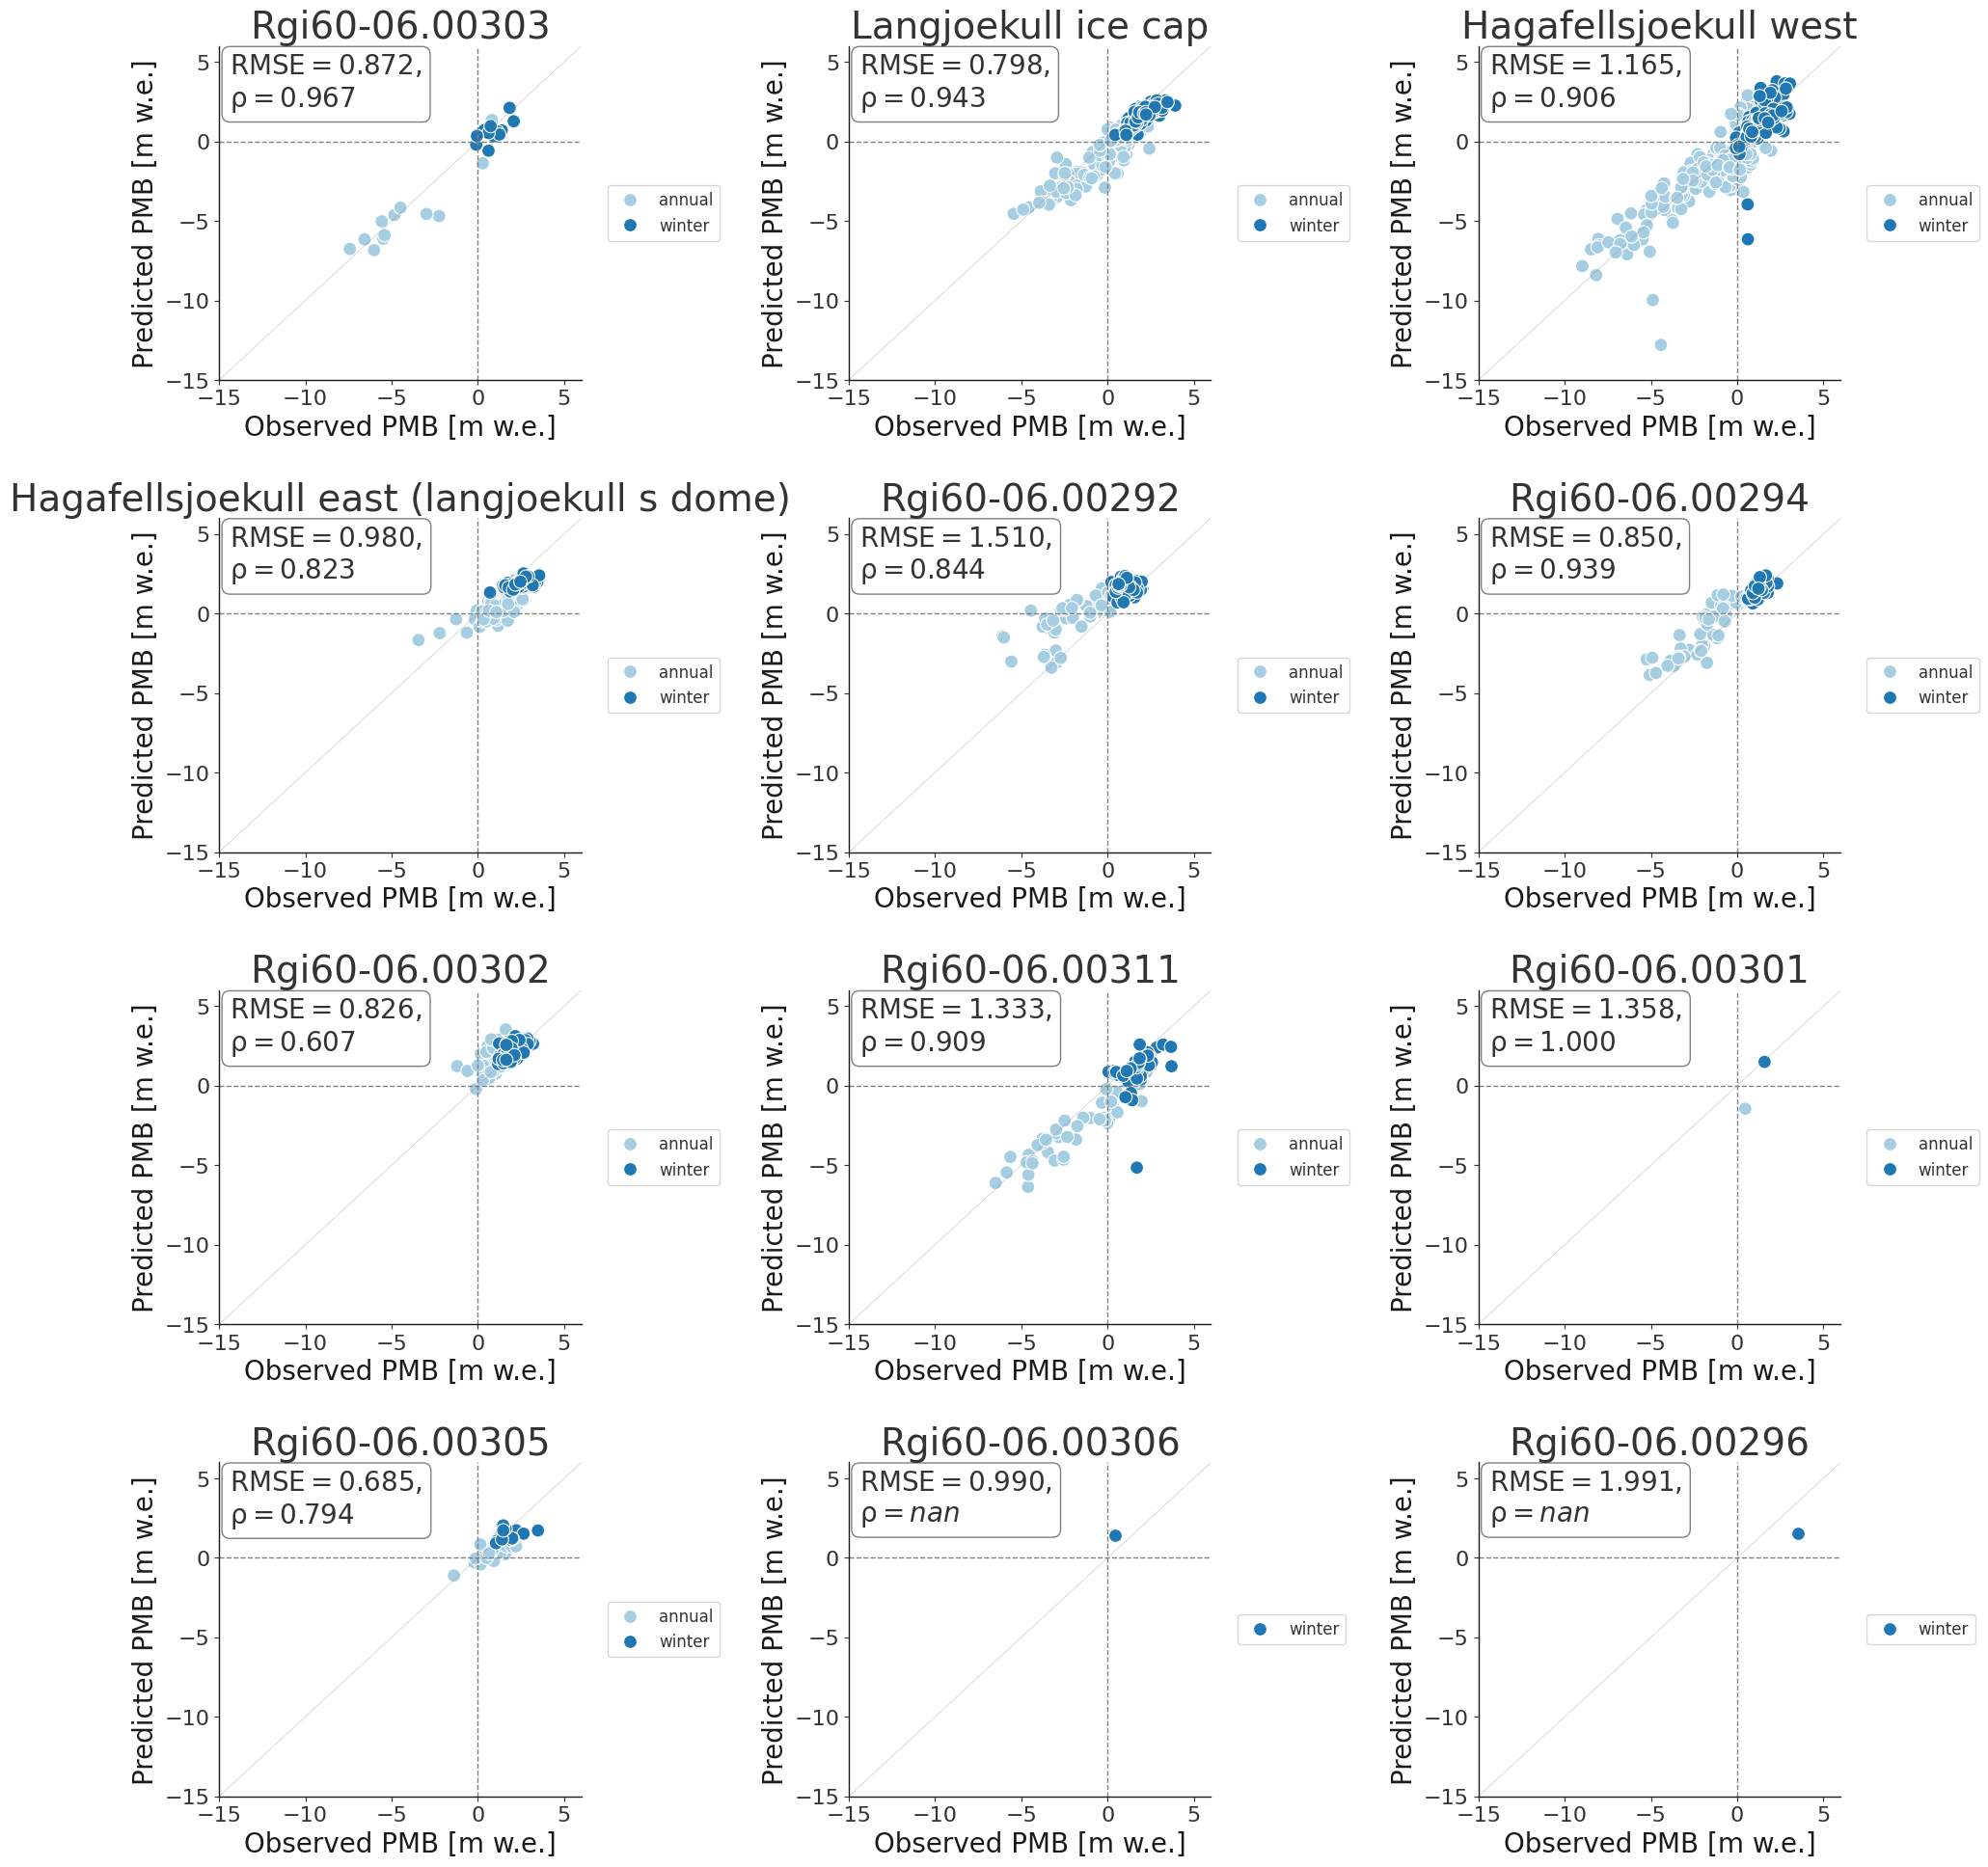

In [21]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

In [ ]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='Prediction most recent 10 years', include_summer = False)

###### Analyzing problematic predictions in Hagafellsjoekull West

In [22]:
grouped_ids_test = grouped_ids.copy()
grouped_ids_test['pmb_diff'] = grouped_ids_test['target'] - grouped_ids_test['pred']
display(grouped_ids_test[
    (grouped_ids_test['GLACIER'] == 'Hagafellsjoekull West') & 
    (abs(grouped_ids_test['pmb_diff']) > 4)
])
display(grouped_ids_test[grouped_ids_test['POINT_ID'] == 'Hagafellsjoekull West_2005.0_annual_L02'])
display(grouped_ids_test[grouped_ids_test['POINT_ID'] == 'Hagafellsjoekull West_2008.0_annual_L02'])


display(data_monthly[data_monthly['POINT_ID'] == 'Hagafellsjoekull West_2005.0_annual_L02'])
display(data_monthly[data_monthly['POINT_ID'] == 'Hagafellsjoekull West_2006.0_annual_L02'])
display(data_monthly[data_monthly['POINT_ID'] == 'Hagafellsjoekull West_2007.0_annual_L02'])
display(data_monthly[data_monthly['POINT_ID'] == 'Hagafellsjoekull West_2008.0_annual_L02'])

target    YEAR                                 POINT_ID  \
ID                                                              
92   -4.4255  2006.0  Hagafellsjoekull West_2006.0_annual_L02   
93   -4.8910  2007.0  Hagafellsjoekull West_2007.0_annual_L02   
3283  0.6220  2006.0  Hagafellsjoekull West_2006.0_winter_L02   
3284  0.6095  2007.0  Hagafellsjoekull West_2007.0_winter_L02   

                    GLACIER       pred  PERIOD  pmb_diff  
ID                                                        
92    Hagafellsjoekull West -12.797798  annual  8.372298  
93    Hagafellsjoekull West  -9.976252  annual  5.085252  
3283  Hagafellsjoekull West  -6.152007  winter  6.774007  
3284  Hagafellsjoekull West  -3.963931  winter  4.573431

target    YEAR                                 POINT_ID  \
ID                                                            
91  -3.455  2005.0  Hagafellsjoekull West_2005.0_annual_L02   

                  GLACIER      pred  PERIOD  pmb_diff  
ID                                                     
91  Hagafellsjoekull West -4.042272  annual  0.587272

target    YEAR                                 POINT_ID  \
ID                                                            
94 -4.8685  2008.0  Hagafellsjoekull West_2008.0_annual_L02   

                  GLACIER      pred  PERIOD  pmb_diff  
ID                                                     
94  Hagafellsjoekull West -4.144308  annual -0.724192

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
1106  2005.0  -20.44524   64.51884         -3.455        697.604104   
1107  2005.0  -20.44524   64.51884         -3.455        697.604104   
1108  2005.0  -20.44524   64.51884         -3.455        697.604104   
1109  2005.0  -20.44524   64.51884         -3.455        697.604104   
1110  2005.0  -20.44524   64.51884         -3.455        697.604104   
1111  2005.0  -20.44524   64.51884         -3.455        697.604104   
1112  2005.0  -20.44524   64.51884         -3.455        697.604104   
1113  2005.0  -20.44524   64.51884         -3.455        697.604104   
1114  2005.0  -20.44524   64.51884         -3.455        697.604104   
1115  2005.0  -20.44524   64.51884         -3.455        697.604104   
1116  2005.0  -20.44524   64.51884         -3.455        697.604104   

      ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
1106            -18.604104            679.0  RGI60-06.00291   
1107            -18.604104            679.0  RGI60-06.00291   
1108            -18.604104            679.0  RGI60-06.00291   
1109            -18.604104            679.0  RGI60-06.00291   
1110            -18.604104            679.0  RGI60-06.00291   
1111            -18.604104            679.0  RGI60-06.00291   
1112            -18.604104            679.0  RGI60-06.00291   
1113            -18.604104            679.0  RGI60-06.00291   
1114            -18.604104            679.0  RGI60-06.00291   
1115            -18.604104            679.0  RGI60-06.00291   
1116            -18.604104            679.0  RGI60-06.00291   

                                     POINT_ID  ID  ...   millan_v       t2m  \
1106  Hagafellsjoekull West_2005.0_annual_L02  91  ...  14.780278 -5.740082   
1107  Hagafellsjoekull West_2005.0_annual_L02  91  ...  14.780278 -8.268890   
1108  Hagafellsjoekull West_2005.0_annual_L02  91  ...  14.780278 -7.438080   
1109  Hagafellsjoekull West_2005.0_annual_L02  91  ...  14.780278 -5.287842   
1110  Hagafellsjoekull West_2005.0_annual_L02  91  ...  14.780278 -3.139252   
1111  Hagafellsjoekull West_2005.0_annual_L02  91  ...  14.780278 -1.567963   
1112  Hagafellsjoekull West_2005.0_annual_L02  91  ...  14.780278  0.471344   
1113  Hagafellsjoekull West_2005.0_annual_L02  91  ...  14.780278  5.770416   
1114  Hagafellsjoekull West_2005.0_annual_L02  91  ...  14.780278  9.018463   
1115  Hagafellsjoekull West_2005.0_annual_L02  91  ...  14.780278  6.044586   
1116  Hagafellsjoekull West_2005.0_annual_L02  91  ...  14.780278  0.780182   

            tp       slhf       sshf        ssrd       fal        str  \
1106  0.008945   171860.0   619376.0    835676.0  0.786766 -1113670.0   
1107  0.009208   286750.0   885002.0    169680.0  0.849603 -1672406.0   
1108  0.006489   251984.0   716154.0    491032.0  0.831851 -1183814.0   
1109  0.006962    83732.0   423746.0   2735446.0  0.817500 -1787232.0   
1110  0.003691    21204.0   654418.0   6601222.0  0.727758 -2018930.0   
1111  0.003656  -476140.0   613030.0  13206492.0  0.730656 -2695413.0   
1112  0.001678 -1462400.0   251868.0  19928904.0  0.604284 -4017570.0   
1113  0.004326 -1443168.0  -387534.0  16723112.0  0.391756 -1982611.0   
1114  0.004316 -5015682.0 -3195420.0  15298186.0  0.133768 -4042268.0   
1115  0.005242 -3343000.0 -2147238.0  10293940.0  0.144014 -3168314.0   
1116  0.003487 -1488934.0  -330240.0   7236027.0  0.370120 -2886168.0   

           u10       v10  
1106 -0.808016 -0.193305  
1107 -0.231770  0.619059  
1108 -0.201732  0.348948  
1109  0.219162  0.492053  
1110 -1.223180 -0.236934  
1111 -1.715254 -0.287315  
1112  0.171519 -0.926011  
1113 -0.114795 -0.126993  
1114 -0.082582  0.588805  
1115 -1.058862 -0.319183  
1116 -0.440113 -1.639704  

[11 rows x 27 columns]

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
1117  2006.0  -20.44556    64.5186        -4.4255        697.604104   
1118  2006.0  -20.44556    64.5186        -4.4255        697.604104   
1119  2006.0  -20.44556    64.5186        -4.4255        697.604104   
1120  2006.0  -20.44556    64.5186        -4.4255        697.604104   
1121  2006.0  -20.44556    64.5186        -4.4255        697.604104   
1122  2006.0  -20.44556    64.5186        -4.4255        697.604104   
1123  2006.0  -20.44556    64.5186        -4.4255        697.604104   
1124  2006.0  -20.44556    64.5186        -4.4255        697.604104   
1125  2006.0  -20.44556    64.5186        -4.4255        697.604104   
1126  2006.0  -20.44556    64.5186        -4.4255        697.604104   
1127  2006.0  -20.44556    64.5186        -4.4255        697.604104   
1128  2006.0  -20.44556    64.5186        -4.4255        697.604104   
1129  2006.0  -20.44556    64.5186        -4.4255        697.604104   

      ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
1117            -21.604104            676.0  RGI60-06.00291   
1118            -21.604104            676.0  RGI60-06.00291   
1119            -21.604104            676.0  RGI60-06.00291   
1120            -21.604104            676.0  RGI60-06.00291   
1121            -21.604104            676.0  RGI60-06.00291   
1122            -21.604104            676.0  RGI60-06.00291   
1123            -21.604104            676.0  RGI60-06.00291   
1124            -21.604104            676.0  RGI60-06.00291   
1125            -21.604104            676.0  RGI60-06.00291   
1126            -21.604104            676.0  RGI60-06.00291   
1127            -21.604104            676.0  RGI60-06.00291   
1128            -21.604104            676.0  RGI60-06.00291   
1129            -21.604104            676.0  RGI60-06.00291   

                                     POINT_ID  ID  ...   millan_v       t2m  \
1117  Hagafellsjoekull West_2006.0_annual_L02  92  ...  11.960814 -3.300629   
1118  Hagafellsjoekull West_2006.0_annual_L02  92  ...  11.960814 -5.048431   
1119  Hagafellsjoekull West_2006.0_annual_L02  92  ...  11.960814 -4.566986   
1120  Hagafellsjoekull West_2006.0_annual_L02  92  ...  11.960814 -4.819183   
1121  Hagafellsjoekull West_2006.0_annual_L02  92  ...  11.960814 -2.829681   
1122  Hagafellsjoekull West_2006.0_annual_L02  92  ...  11.960814 -6.211273   
1123  Hagafellsjoekull West_2006.0_annual_L02  92  ...  11.960814 -4.355804   
1124  Hagafellsjoekull West_2006.0_annual_L02  92  ...  11.960814  0.746002   
1125  Hagafellsjoekull West_2006.0_annual_L02  92  ...  11.960814  4.151764   
1126  Hagafellsjoekull West_2006.0_annual_L02  92  ...  11.960814  7.275055   
1127  Hagafellsjoekull West_2006.0_annual_L02  92  ...  11.960814  7.844635   
1128  Hagafellsjoekull West_2006.0_annual_L02  92  ...  11.960814  5.708893   
1129  Hagafellsjoekull West_2006.0_annual_L02  92  ...  11.960814 -3.300629   

            tp       slhf       sshf        ssrd       fal        str  \
1117  0.005432    89310.0   808426.0   3214275.0  0.729689 -1605384.0   
1118  0.005781   152576.0   634150.0    781776.0  0.836494 -1247500.0   
1119  0.010001   291432.0   657030.0    164760.0  0.838906 -1306820.0   
1120  0.012181   290032.0   609192.0    468720.0  0.840671 -1090987.0   
1121  0.007167   228858.0   634816.0   2434388.0  0.752681 -1822114.0   
1122  0.002011  -226712.0   463376.0   8027673.0  0.727819 -2971556.0   
1123  0.005899  -102282.0   384646.0  15651574.0  0.831683 -2900387.0   
1124  0.002532 -1139856.0   195520.0  19259040.0  0.612456 -3590081.0   
1125  0.006869    85780.0   827226.0  14091856.0  0.540285  -794972.0   
1126  0.004562 -3053908.0 -1564826.0  12624524.0  0.206095 -2646669.0   
1127  0.001957 -3252616.0 -1985730.0  10558056.0  0.134752 -3413108.0   
1128  0.005584 -2104142.0  -769298.0   7050577.0  0.139560 -2983464.0   
1129  0.005432    89310.0   808426.0   3214275.0  0.729689 -1605384.0   



YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
1130  2007.0  -20.44537   64.51887         -4.891        697.604104   
1131  2007.0  -20.44537   64.51887         -4.891        697.604104   
1132  2007.0  -20.44537   64.51887         -4.891        697.604104   
1133  2007.0  -20.44537   64.51887         -4.891        697.604104   
1134  2007.0  -20.44537   64.51887         -4.891        697.604104   
1135  2007.0  -20.44537   64.51887         -4.891        697.604104   
1136  2007.0  -20.44537   64.51887         -4.891        697.604104   
1137  2007.0  -20.44537   64.51887         -4.891        697.604104   
1138  2007.0  -20.44537   64.51887         -4.891        697.604104   
1139  2007.0  -20.44537   64.51887         -4.891        697.604104   
1140  2007.0  -20.44537   64.51887         -4.891        697.604104   

      ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
1130            -21.604104            676.0  RGI60-06.00291   
1131            -21.604104            676.0  RGI60-06.00291   
1132            -21.604104            676.0  RGI60-06.00291   
1133            -21.604104            676.0  RGI60-06.00291   
1134            -21.604104            676.0  RGI60-06.00291   
1135            -21.604104            676.0  RGI60-06.00291   
1136            -21.604104            676.0  RGI60-06.00291   
1137            -21.604104            676.0  RGI60-06.00291   
1138            -21.604104            676.0  RGI60-06.00291   
1139            -21.604104            676.0  RGI60-06.00291   
1140            -21.604104            676.0  RGI60-06.00291   

                                     POINT_ID  ID  ...   millan_v       t2m  \
1130  Hagafellsjoekull West_2007.0_annual_L02  93  ...  14.780278 -7.198090   
1131  Hagafellsjoekull West_2007.0_annual_L02  93  ...  14.780278 -4.638031   
1132  Hagafellsjoekull West_2007.0_annual_L02  93  ...  14.780278 -8.623627   
1133  Hagafellsjoekull West_2007.0_annual_L02  93  ...  14.780278 -7.766693   
1134  Hagafellsjoekull West_2007.0_annual_L02  93  ...  14.780278 -4.264008   
1135  Hagafellsjoekull West_2007.0_annual_L02  93  ...  14.780278 -0.790375   
1136  Hagafellsjoekull West_2007.0_annual_L02  93  ...  14.780278  0.140289   
1137  Hagafellsjoekull West_2007.0_annual_L02  93  ...  14.780278  6.091217   
1138  Hagafellsjoekull West_2007.0_annual_L02  93  ...  14.780278  9.790924   
1139  Hagafellsjoekull West_2007.0_annual_L02  93  ...  14.780278  6.421783   
1140  Hagafellsjoekull West_2007.0_annual_L02  93  ...  14.780278  2.614166   

            tp       slhf       sshf        ssrd       fal        str  \
1130  0.007058    35688.0  1124108.0    997284.0  0.795310 -1696648.0   
1131  0.010460   358266.0   807708.0    160984.0  0.794976 -1241260.0   
1132  0.004179   224778.0   738372.0    475620.0  0.805713 -1535988.0   
1133  0.003633   171392.0  1045868.0   3003758.0  0.806468 -2779250.0   
1134  0.009681   161542.0   680278.0   6906958.0  0.838537 -1843356.0   
1135  0.006796  -295526.0   219458.0  12622800.0  0.729541 -2215456.0   
1136  0.002051 -1208574.0   304592.0  19812520.0  0.630099 -3866738.0   
1137  0.001778 -1297328.0   462728.0  17557752.0  0.460527 -1790700.0   
1138  0.002831 -5503624.0 -3178348.0  16997060.0  0.133799 -5033435.0   
1139  0.004848 -3392090.0 -2305338.0  11107394.0  0.134676 -3537918.0   
1140  0.008929 -1228350.0  -127276.0   5313865.0  0.308143 -1914796.0   

           u10       v10  
1130 -1.651969 -1.313510  
1131 -1.077040  0.742627  
1132 -0.389222 -0.632123  
1133 -1.955219 -0.883820  
1134 -0.901656  1.195910  
1135 -1.047737  0.943120  
1136 -1.020650 -0.892584  
1137 -0.732829  0.127923  
1138 -0.272125 -0.394845  
1139 -0.435301 -0.580100  
1140 -0.715057  0.027251  

[11 rows x 27 columns]

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
1141  2008.0   -20.4452   64.51885        -4.8685        697.604104   
1142  2008.0   -20.4452   64.51885        -4.8685        697.604104   
1143  2008.0   -20.4452   64.51885        -4.8685        697.604104   
1144  2008.0   -20.4452   64.51885        -4.8685        697.604104   
1145  2008.0   -20.4452   64.51885        -4.8685        697.604104   
1146  2008.0   -20.4452   64.51885        -4.8685        697.604104   
1147  2008.0   -20.4452   64.51885        -4.8685        697.604104   
1148  2008.0   -20.4452   64.51885        -4.8685        697.604104   
1149  2008.0   -20.4452   64.51885        -4.8685        697.604104   
1150  2008.0   -20.4452   64.51885        -4.8685        697.604104   
1151  2008.0   -20.4452   64.51885        -4.8685        697.604104   
1152  2008.0   -20.4452   64.51885        -4.8685        697.604104   

      ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
1141            -28.604104            669.0  RGI60-06.00291   
1142            -28.604104            669.0  RGI60-06.00291   
1143            -28.604104            669.0  RGI60-06.00291   
1144            -28.604104            669.0  RGI60-06.00291   
1145            -28.604104            669.0  RGI60-06.00291   
1146            -28.604104            669.0  RGI60-06.00291   
1147            -28.604104            669.0  RGI60-06.00291   
1148            -28.604104            669.0  RGI60-06.00291   
1149            -28.604104            669.0  RGI60-06.00291   
1150            -28.604104            669.0  RGI60-06.00291   
1151            -28.604104            669.0  RGI60-06.00291   
1152            -28.604104            669.0  RGI60-06.00291   

                                     POINT_ID  ID  ...   millan_v       t2m  \
1141  Hagafellsjoekull West_2008.0_annual_L02  94  ...  14.780278  0.201569   
1142  Hagafellsjoekull West_2008.0_annual_L02  94  ...  14.780278 -4.328949   
1143  Hagafellsjoekull West_2008.0_annual_L02  94  ...  14.780278 -6.082611   
1144  Hagafellsjoekull West_2008.0_annual_L02  94  ...  14.780278 -7.583832   
1145  Hagafellsjoekull West_2008.0_annual_L02  94  ...  14.780278 -6.541107   
1146  Hagafellsjoekull West_2008.0_annual_L02  94  ...  14.780278 -5.336517   
1147  Hagafellsjoekull West_2008.0_annual_L02  94  ...  14.780278 -3.450043   
1148  Hagafellsjoekull West_2008.0_annual_L02  94  ...  14.780278  2.588043   
1149  Hagafellsjoekull West_2008.0_annual_L02  94  ...  14.780278  5.195953   
1150  Hagafellsjoekull West_2008.0_annual_L02  94  ...  14.780278  9.796051   
1151  Hagafellsjoekull West_2008.0_annual_L02  94  ...  14.780278  7.257477   
1152  Hagafellsjoekull West_2008.0_annual_L02  94  ...  14.780278  4.225250   

            tp       slhf       sshf        ssrd       fal        str  \
1141  0.015851  -213106.0   236252.0   2647273.0  0.391020 -1532600.0   
1142  0.007859    43644.0   684586.0    869260.0  0.791435 -1386556.0   
1143  0.011318   383882.0  1118458.0    181560.0  0.822518 -1823444.0   
1144  0.006473   201942.0   918104.0    539488.0  0.824725 -2011715.0   
1145  0.008607   183180.0   920114.0   2529812.0  0.834595 -1864014.0   
1146  0.003911     4794.0   636324.0   7836477.0  0.846124 -2305620.0   
1147  0.001675  -290654.0   418153.0  15874490.0  0.788989 -3355708.0   
1148  0.002520  -231146.0   404616.0  13994984.0  0.561270 -1173179.0   
1149  0.002351 -1889238.0   -74568.0  21168250.0  0.427538 -3477864.0   
1150  0.003057 -5689670.0 -2727472.0  16306892.0  0.133783 -4572174.0   
1151  0.004814 -3633046.0 -1916506.0  11120160.0  0.135393 -3798067.0   
1152  0.012458 -1699094.0  -580288.0   5917705.0  0.207401 -2262592.0   

           u10       v10  
1141 -1.179562  1.415508  
1142 -0.736665 -0.159671  
1143 -1.936496  1.265792  
1144 -1.538512  0.545691  
1145 -0.417540  1.176327  
1146 -1.127824 -1.126515  
1147 -1.784403 -1.473724  
1148 -1.304642  0.310011  
1149 -1.457090 -0.910849  
1150 -1.171265  

Available years: [2005, 2006, 2007, 2008]


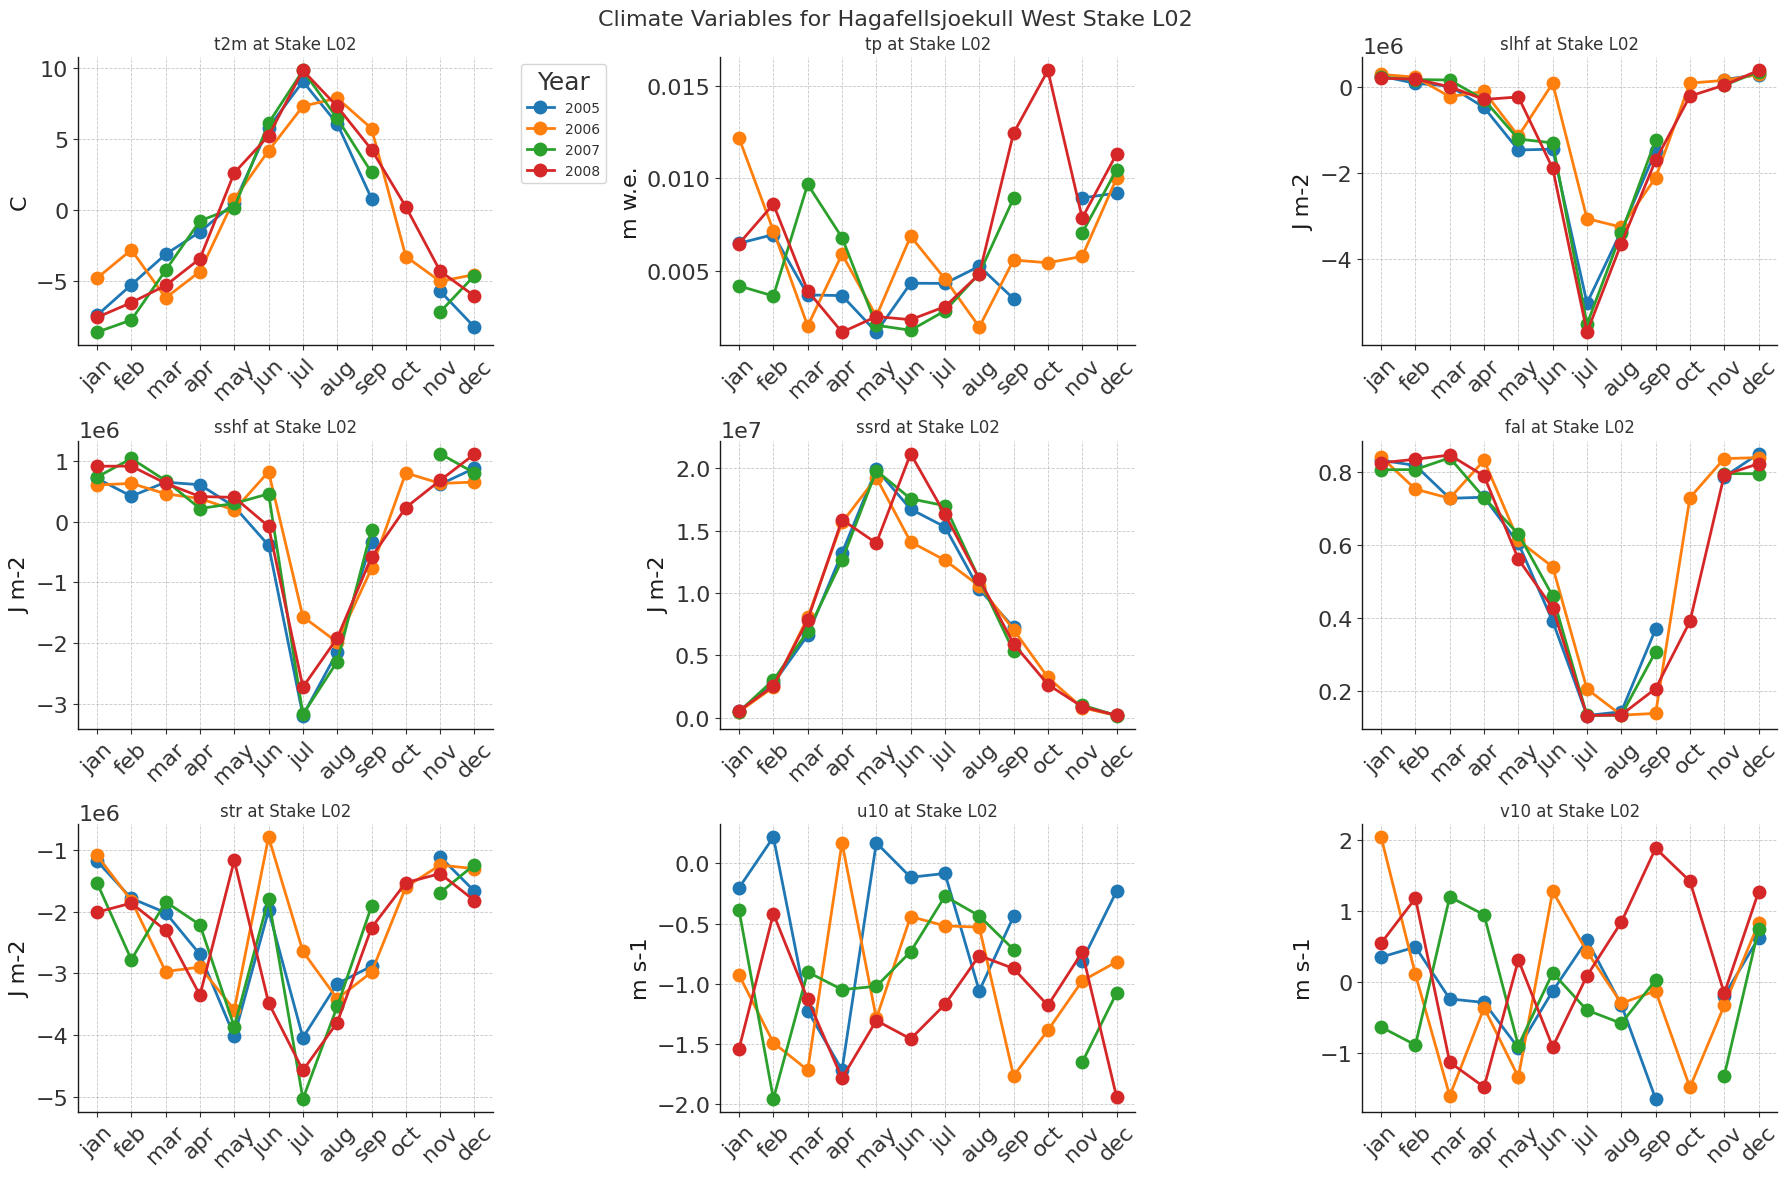

In [23]:
## Plot climate variables for Hagafellsjoekull West Stake L02 nonproblematic year 2005 and 2008 and problematic year 2006 and 2007
stake_l02_data = data_monthly[data_monthly['POINT_ID'].str.contains('Hagafellsjoekull West_.+_annual_L02')]

plt.figure(figsize=(18, 12))

years_to_compare = [2005, 2006, 2007, 2008]
print(f"Available years: {years_to_compare}")

month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Plot each climate variable
for var_idx, var in enumerate(vois_climate):
    ax = plt.subplot(3, 3, var_idx+1)
    
    # Group by year and month, taking mean if multiple values exist
    pivot_data = stake_l02_data.pivot_table(
        index='MONTHS', columns='YEAR', values=var, aggfunc='mean')
    
    for year in years_to_compare:
        if year in pivot_data.columns:
            # Get x and y values in correct month order
            valid_months = [m for m in month_order if m in pivot_data.index]
            x_pos = [month_order.index(m) for m in valid_months]
            y_vals = [pivot_data.loc[m, year] for m in valid_months]
            
            ax.plot(x_pos, y_vals, marker='o', linewidth=2, label=f'{int(year)}')
    
    ax.set_title(f'{var} at Stake L02', fontsize=12)
    ax.set_ylabel(vois_units.get(var, ''))
    ax.set_xticks(range(len(month_order)))
    ax.set_xticklabels(month_order, rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend only to the first plot
    if var_idx == 0:
        ax.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Climate Variables for Hagafellsjoekull West Stake L02', fontsize=16)
plt.tight_layout()
plt.show()

### B.1. Train CH Test ICE

In [28]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
data_ICE = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/csv/ICE_dataset_all_oggm.csv')

display(data_CH.columns)

display(data_ICE.columns)

data_CH = data_CH.drop(['hugonnet_dhdt', 'aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with ICE
data_ICE_CH = pd.concat([data_ICE, data_CH], axis=0).reset_index(drop=True)

display(data_ICE_CH.head(2))

display(len(data_ICE_CH['GLACIER'].unique()))

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

Index(['POINT_ELEVATION', 'POINT_LAT', 'POINT_LON', 'DATA_MODIFICATION',
       'FROM_DATE', 'TO_DATE', 'POINT_BALANCE', 'PERIOD', 'YEAR', 'RGIId',
       'aspect', 'slope', 'topo', 'consensus_ice_thickness', 'millan_v',
       'GLACIER', 'POINT_ID'],
      dtype='object')

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

POINT_ELEVATION  POINT_LAT  POINT_LON  \
0          1744.39  64.555705 -17.410172   
1          1594.20  64.529965 -17.007155   

                                DATA_MODIFICATION  FROM_DATE   TO_DATE  \
0                                             NaN   20060925  20071010   
1  Dates filled in according to hydrological year   19921001  19930928   

   POINT_BALANCE  PERIOD    YEAR           RGIId      aspect     slope  \
0       1.785833  annual  2007.0  RGI60-06.00475  151.898407  0.876541   
1       3.375500  annual  1993.0  RGI60-06.00477   10.779899  1.033374   

          topo  consensus_ice_thickness  millan_v           GLACIER  \
0  1740.480713               488.543335  26.53290  Skeidararjoekull   
1  1573.148926               589.661133  40.94659     Dyngjujoekull   

                                POINT_ID  
0  Skeidararjoekull_2007.0_annual_Gjal28  
1        Dyngjujoekull_1993.0_annual_D09

88

###### Add ERA5Land data to the combined CH_ICE stakes

In [30]:
data_CH_ICE_test = data_ICE_CH.copy()

display(data_CH_ICE_test.shape)
display(data_CH_ICE_test.head(2))

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_WGMS_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data_ICECH.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_CH_ICE_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_ICE_wgms_dataset_monthly_full.csv')
data_monthly_CH_ICE = dataloader_gl.data

display(data_monthly_CH_ICE.head(2))

(39904, 17)

POINT_ELEVATION  POINT_LAT  POINT_LON  \
0          1744.39  64.555705 -17.410172   
1          1594.20  64.529965 -17.007155   

                                DATA_MODIFICATION  FROM_DATE   TO_DATE  \
0                                             NaN   20060925  20071010   
1  Dates filled in according to hydrological year   19921001  19930928   

   POINT_BALANCE  PERIOD    YEAR           RGIId      aspect     slope  \
0       1.785833  annual  2007.0  RGI60-06.00475  151.898407  0.876541   
1       3.375500  annual  1993.0  RGI60-06.00477   10.779899  1.033374   

          topo  consensus_ice_thickness  millan_v           GLACIER  \
0  1740.480713               488.543335  26.53290  Skeidararjoekull   
1  1573.148926               589.661133  40.94659     Dyngjujoekull   

                                POINT_ID  
0  Skeidararjoekull_2007.0_annual_Gjal28  
1        Dyngjujoekull_1993.0_annual_D09

2025-06-09 20:33:16,126 - INFO - Number of annual and seasonal samples: 39904
2025-06-09 20:33:16,130 - INFO - Running on 88 glaciers:
['Skeidararjoekull' 'Dyngjujoekull' 'Breidamerkurjoekull' 'RGI60-06.00303'
 'Langjoekull Ice Cap' 'Hagafellsjoekull West'
 'Sidujoekull/Skaftarjoekull' 'Koeldukvislarjoekull' 'RGI60-06.00359'
 'RGI60-06.00238' 'Hagafellsjoekull East (Langjoekull S Dome)'
 'RGI60-06.00466' 'Tungnaarjoekull' 'RGI60-06.00232' 'Bruarjoekull'
 'RGI60-06.00411' 'RGI60-06.00422' 'RGI60-06.00292' 'RGI60-06.00328'
 'RGI60-06.00340' 'Blagnipujoekull (Hofsjoekull SW)' 'RGI60-06.00294'
 'RGI60-06.00302' 'RGI60-06.00311' 'Oeldufellsjoekull' 'Eyjabakkajoekull'
 'RGI60-06.00320' 'RGI60-06.00478' 'RGI60-06.00465' 'RGI60-06.00301'
 'RGI60-06.00305' 'RGI60-06.00409' 'Sylgjujoekull'
 'Thjorsarjoekull (Hofsjoekull E)' 'RGI60-06.00480' 'RGI60-06.00476'
 'RGI60-06.00413' 'RGI60-06.00350' 'Mulajoekull' 'RGI60-06.00349'
 'Slettjoekull West' 'RGI60-06.00228' 'RGI60-06.00342' 'RGI60-06.00425'
 '

YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2007.0 -17.410172  64.555705       1.785833       1703.715905   
1  2007.0 -17.410172  64.555705       1.785833       1703.715905   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0             40.674095          1744.39  RGI60-06.00475   
1             40.674095          1744.39  RGI60-06.00475   

                                POINT_ID  ID  ...  millan_v        t2m  \
0  Skeidararjoekull_2007.0_annual_Gjal28   0  ...   26.5329  -5.689545   
1  Skeidararjoekull_2007.0_annual_Gjal28   0  ...   26.5329 -10.739105   

         tp      slhf      sshf       ssrd       fal        str       u10  \
0  0.004581 -135748.0  482898.0  4067512.0  0.850005 -1431300.0 -3.467090   
1  0.006718  193162.0  744062.0   919344.0  0.849998 -1265354.0 -1.604117   

        v10  
0 -0.109194  
1  0.086881  

[2 rows x 27 columns]

###### Test and Train set

In [32]:
test_glaciers = list(data_ICE['GLACIER'].unique())

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = list(data_CH['GLACIER'].unique())

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 62082
Size of train data: 290682
Percentage of test size: 21.36%
Train:
Number of winter and annual samples: 290682
Number of annual samples: 87440
Number of winter samples: 203242
Test:
Number of winter and annual samples: 62082
Number of annual samples: 38594
Number of winter samples: 23488
Total:
Number of monthly rows: 352764
Number of annual rows: 126034
Number of winter rows: 226730


##### B.2. Train-Test set plots

In [ ]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

#### B.4. XGBoost

In [36]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    #"hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

#### Grid Search

In [37]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'CH_train_ICE_test.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'CH_train_ICE_test.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (290682, 25)
Shape of testing dataset: (62082, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'consensus_ice_thickness', 'millan_v']
Best parameters:
 {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.19564066187781454
Shape of the test: (62082, 14)
Overall score: 4.758895367492527
CPU times: user 5.84 s, sys: 0 ns, total: 5.84 s
Wall time: 781 ms


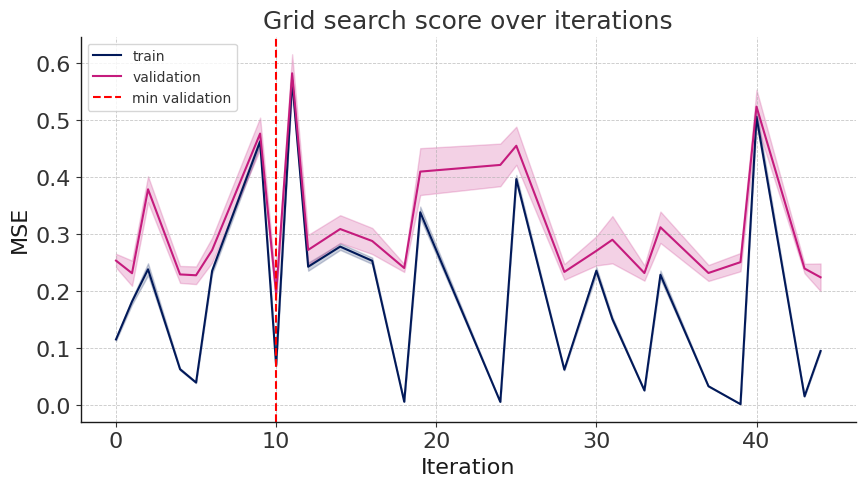

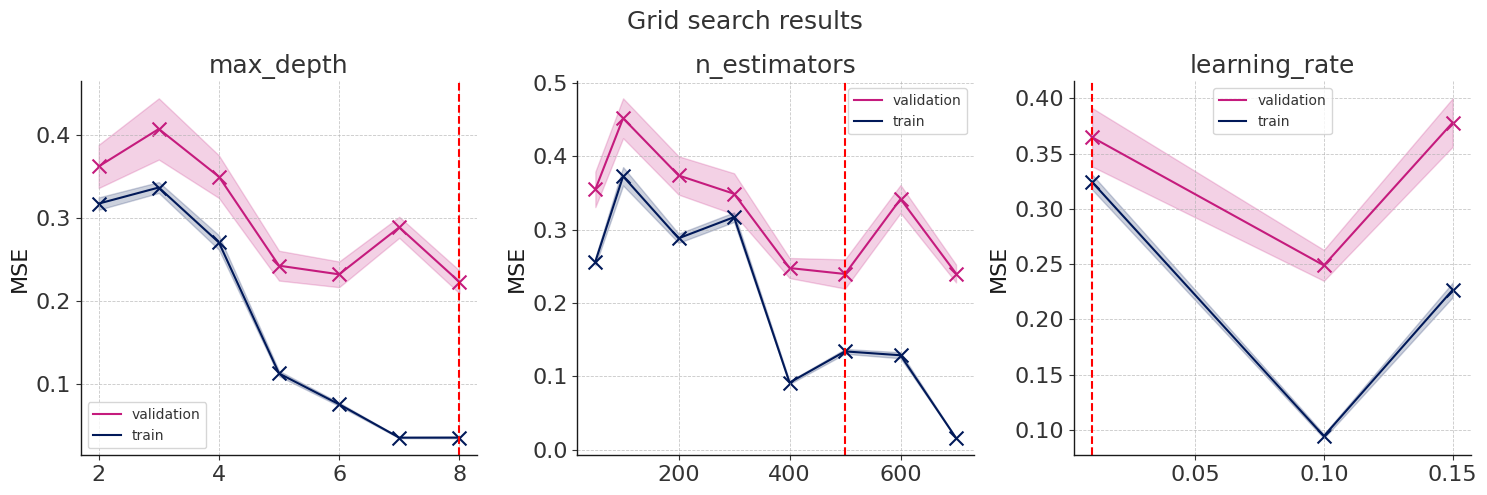

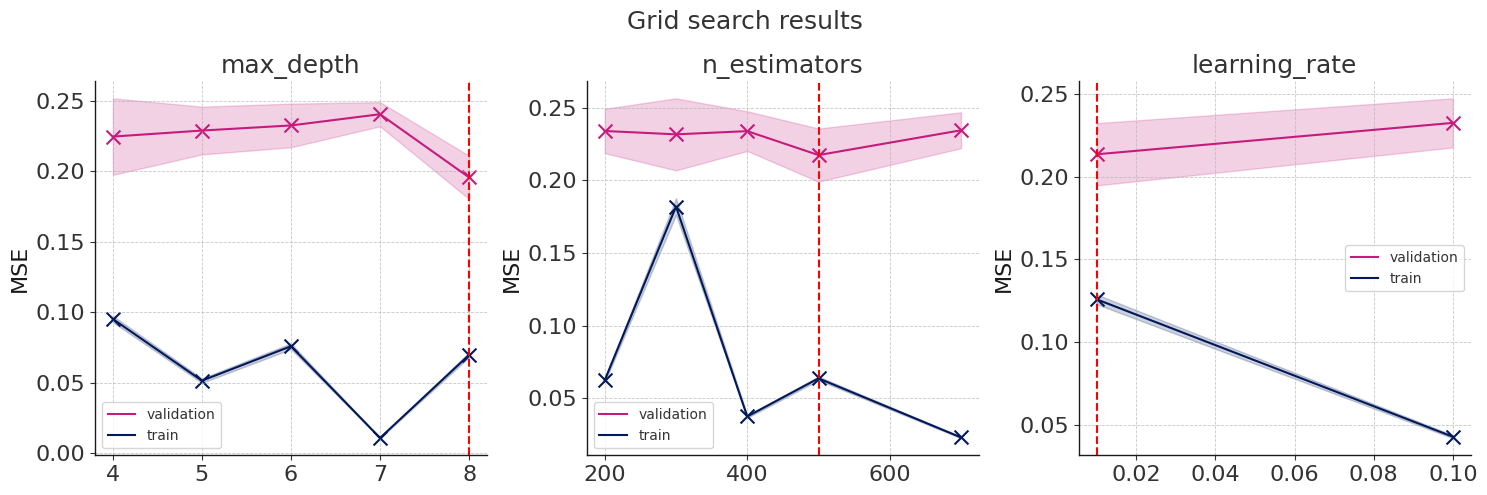

In [ ]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

print_top_n_models(custom_xgboost.param_search.cv_results_)

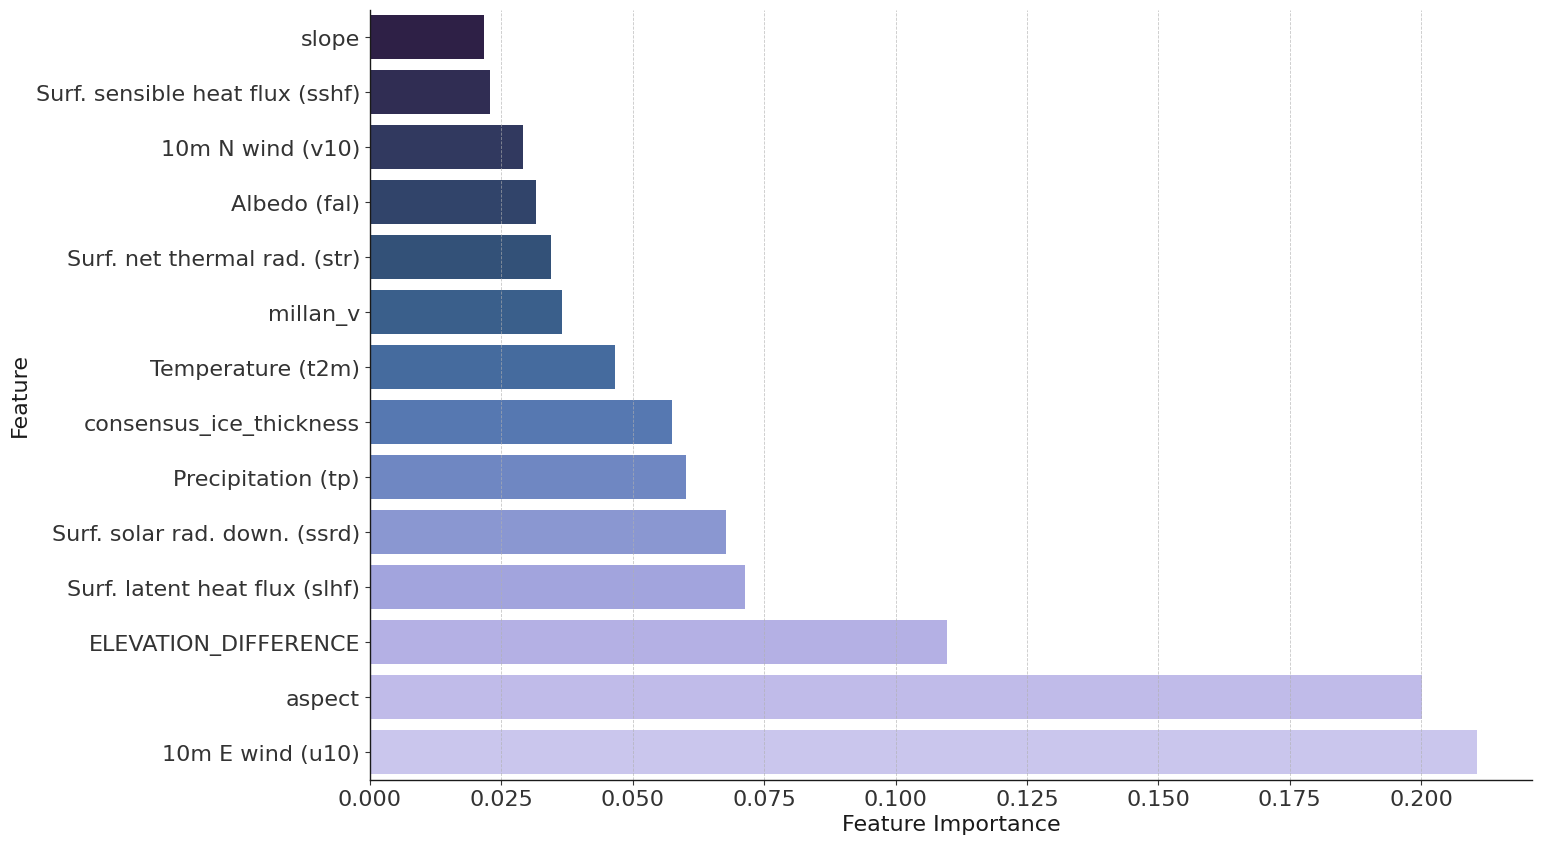

In [39]:
FIPlot(best_estimator, feature_columns, vois_climate)

Shape of the test: (62082, 14)


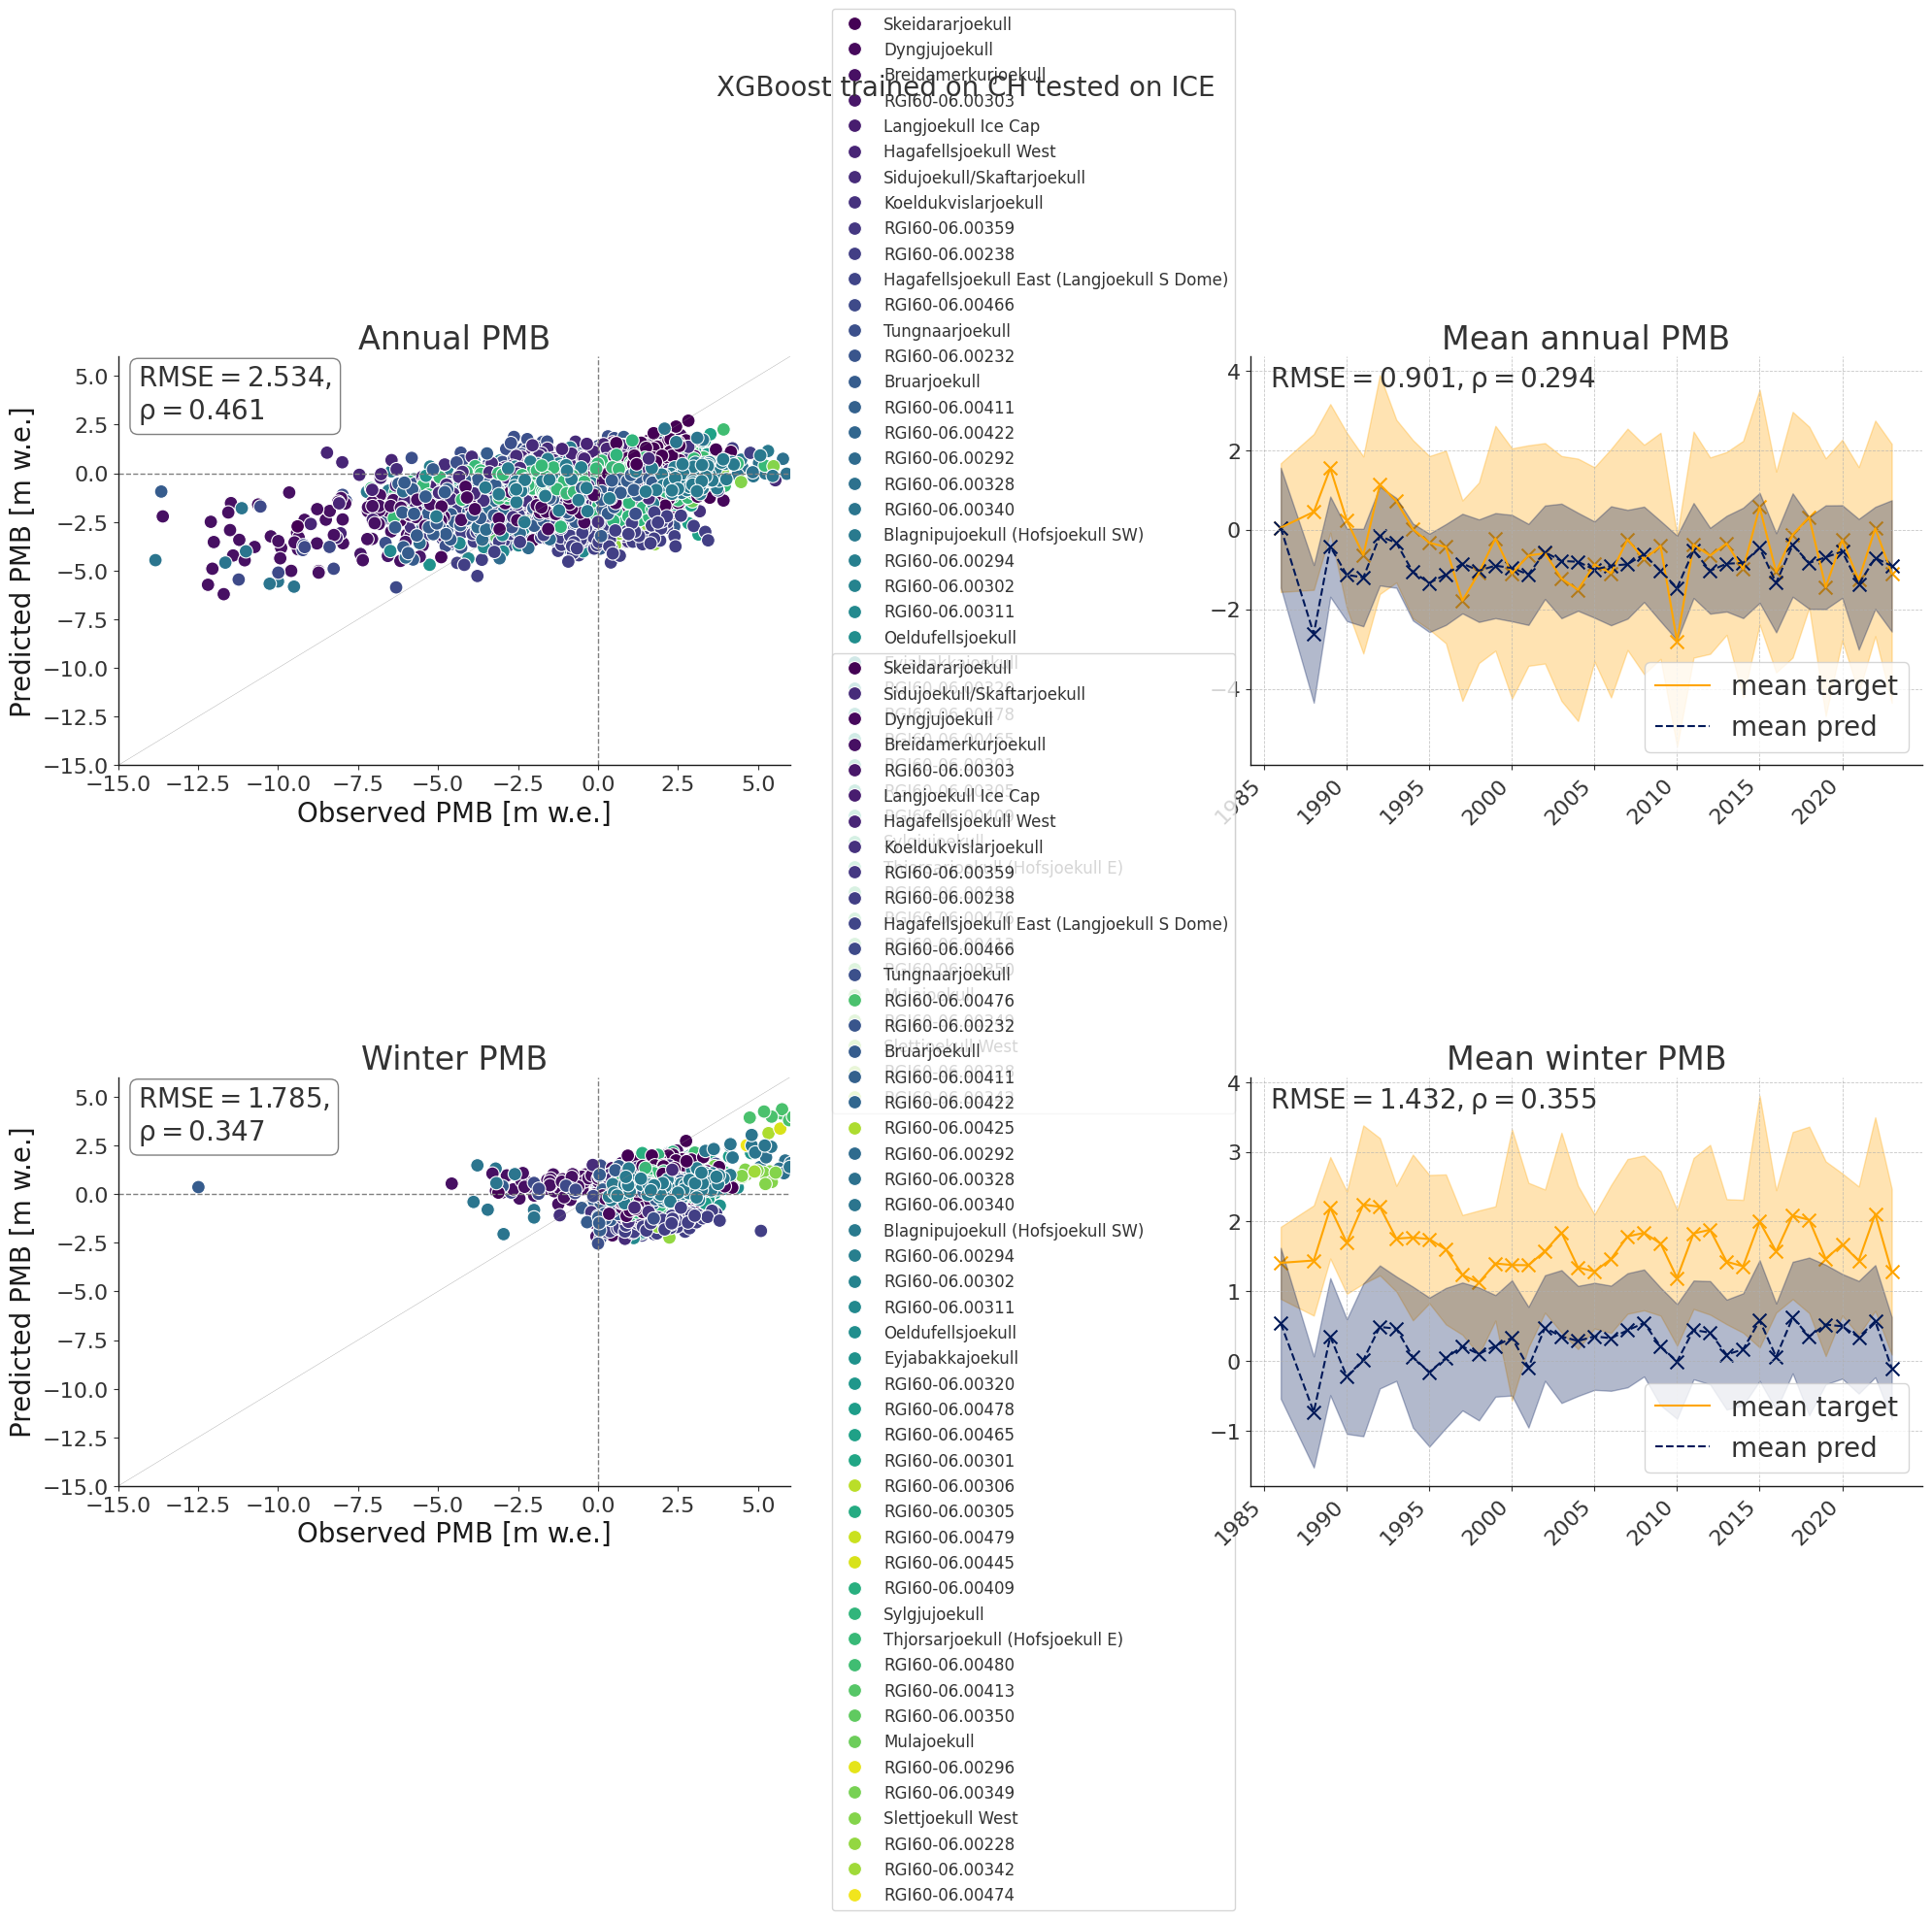

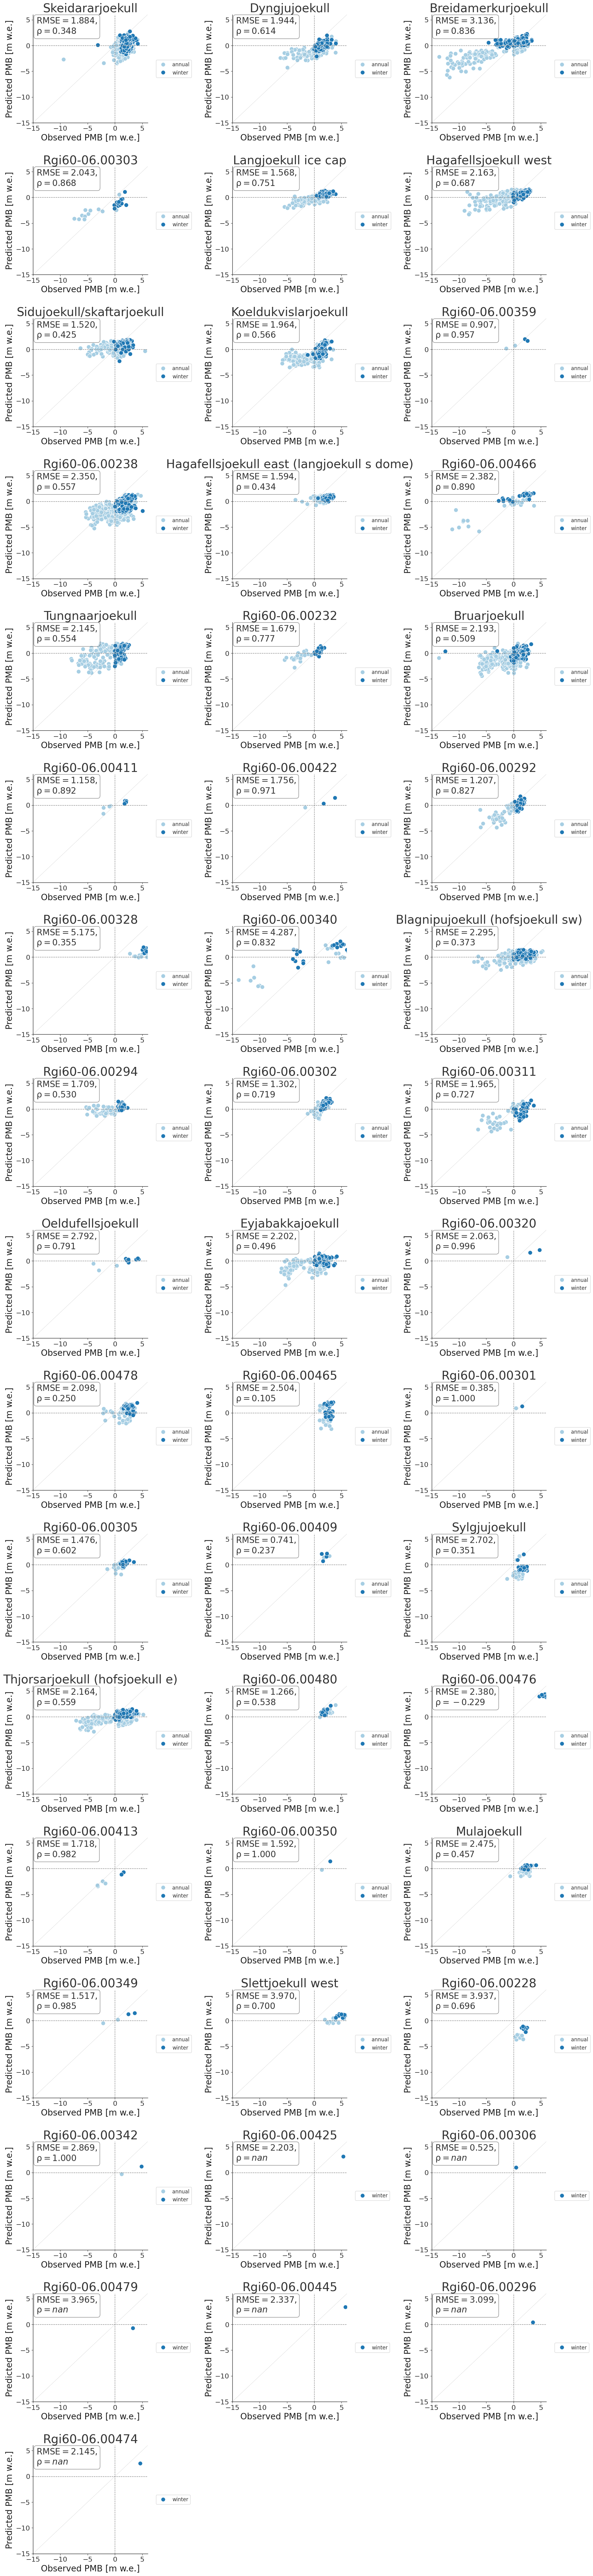

In [40]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)

PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

In [ ]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

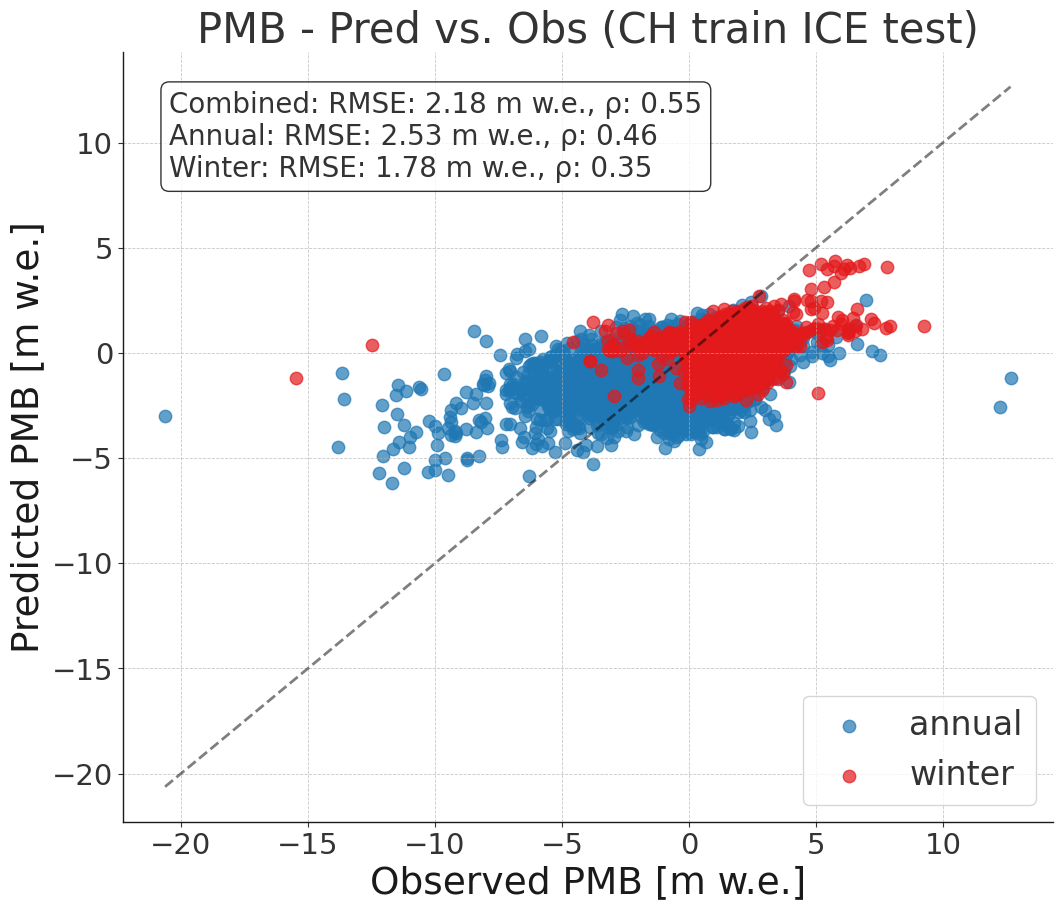

In [ ]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='CH Train ICE Test', include_summer = False)

### Predictions of custom parameters:

In [ ]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

FIPlot(custom_model, feature_columns, vois_climate)